In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from collections import OrderedDict
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# Extras needed
import time
from utils import *

In [2]:
# Modify `generate_train_test_split` to return separate data and labels for DataLoader usage
def generate_train_test_split(count: int, dim: int, n: int, device: torch.device, coord_max: float, test_size: float = 0.2, seed: int = 42):
    all_batches = generate_vector_batches(count, dim, n, device, coord_max, seed)
    labels = torch.arange(count)  # Placeholder labels if needed

    train_indices, test_indices = train_test_split(range(count), test_size=test_size, random_state=seed)
    train_batches, test_batches = all_batches[train_indices], all_batches[test_indices]

    return train_batches, test_batches


In [3]:
class Base_Wasser_NN(nn.Module):
    def __init__(self, n: int, d: int):
        super().__init__()
        self.n = n
        self.d = d
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(OrderedDict([
            ('Lin1', nn.Linear(2 * n * d, 4 * n * d)),
            ('relu1', nn.ReLU()),
            ('Lin2', nn.Linear(4 * n * d, n * n + 2 * n))  # n x n matrix and two n-long vectors
        ]))

    def forward(self, batch):
        # Reshape batch to (batch_size, 2 * n * d) for the Linear layer
        batch_size = batch.size(0)
        flattened_batch = batch.view(batch_size, 2 * self.n * self.d)  # (batch_size, 2 * n * d)
        
        # Pass through the sequential layers
        logits = self.linear_relu_stack(flattened_batch)
        return logits
    def predict_interval(self, batch):
        # Unpack batched vectors from the input batch
        vecs1 = batch[:, 0, :, :]  # Shape: (batch_size, n, d)
        vecs2 = batch[:, 1, :, :]  # Shape: (batch_size, n, d)

        # Forward pass to get predictions
        pred = self.forward(batch)  # Now expects batched output of shape (batch_size, n * n + 2 * n)
        batch_size = pred.size(0)
        
        results = []
        for i in range(batch_size):
            # Compute distance matrix for the i-th element in the batch
            distances_mat = torch.cdist(vecs1[i], vecs2[i], p=2)  # Shape: (n, n)
    
            # Separate the i-th prediction output into its components
            single_pred = pred[i]
            out_put_mat = single_pred[:n * n].view(n, n)  # Shape: (n, n)
            f = single_pred[n * n:n * n + n]              # Shape: (n,)
            g = single_pred[n * n + n:]                   # Shape: (n,)
    
            # Compute primal and dual solutions
            sol_prim = primal_sol(out_put_mat=out_put_mat, distances_mat=distances_mat)
            sol_dual = dual_sol(f=f, g=g, distances_mat=distances_mat)
            
            # Append the result (sol_prim, sol_dual) for each batch element
            results.append((sol_prim, sol_dual))
        
        return results  # Returns a list of tuples, each containing (sol_prim, sol_dual) for a batch element


In [4]:
def make_wass_loss(n: int, d: int):
    def wass_loss(batch, pred):
        # Unpack batched vectors from the input batch
        vecs1 = batch[:, 0, :, :]  # Shape: (batch_size, n, d)
        vecs2 = batch[:, 1, :, :]  # Shape: (batch_size, n, d)

        batch_size = pred.size(0)  # Determine batch size from pred

        # Compute distance matrix for each item in the batch
        total_loss = 0
        for i in range(batch_size):
            distances_mat = torch.cdist(vecs1[i],vecs2[i])  # Shape: (n, n)
            
            # Separate the i-th prediction output into its components
            single_pred = pred[i]
            out_put_mat = single_pred[:n * n].view(n, n)  # Shape: (n, n)
            f = single_pred[n * n:n * n + n]              # Shape: (n,)
            g = single_pred[n * n + n:]                   # Shape: (n,)
            
            # Compute primal and dual solutions for each item in the batch
            sol_prim = primal_sol(out_put_mat=out_put_mat, distances_mat=distances_mat)
            sol_dual = dual_sol(f=f, g=g, distances_mat=distances_mat)
            
            # Accumulate loss
            total_loss += torch.abs(sol_prim - sol_dual)

        # Return average loss across the batch
        return total_loss / batch_size
        
    return wass_loss


In [5]:
def train_model(model, dataloader, loss_fn, optimizer):
    model.train()
    for batch in dataloader:
        batch = batch[0].to(device)  # Extract batch tensor from DataLoader tuple
        optimizer.zero_grad()

        # Forward pass
        logits = model(batch)
        
        # Compute loss
        loss = loss_fn(batch, logits)
        
        # Backward pass and optimization step
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

def test_model(model, dataloader, loss_fn):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch in dataloader:
            batch = batch[0].to(device)
            logits = model(batch)
            loss = loss_fn(batch, logits)
            total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    return avg_loss


In [6]:
# Define parameters
count = 2000
d = 2
n = 4
seed = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
coords_max = 10

# Generate train and test batches
train_batches, test_batches = generate_train_test_split(count=count, dim=d, n=n, device=device, coord_max=coords_max, test_size=0.2, seed=seed)

# Create DataLoaders
batch_size = 16  # Define batch size
train_dataset = TensorDataset(train_batches)
test_dataset = TensorDataset(test_batches)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Model, loss, optimizer
model = Base_Wasser_NN(n=n, d=d).to(device)
loss_fn = make_wass_loss(n=n, d=d)
lr = 1e-2
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Training and testing loop
epochs = 100
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    start_time = time.time()
    # Training
    train_model(model, train_loader, loss_fn, optimizer)
    # Testing
    avg_loss = test_model(model, test_loader, loss_fn)
    print(f"Average Test Loss: {avg_loss:.4f}")
    
    end_time = time.time()
    epoch_duration = end_time - start_time
    print(f"Epoch Run time: {epoch_duration:.2f} seconds.\n")
    print("-------------------------------")

print("Done!")

Epoch 1
-------------------------------
Average Test Loss: 19.3602
Epoch Run time: 6.64 seconds.

-------------------------------
Epoch 2
-------------------------------
Average Test Loss: 18.1883
Epoch Run time: 6.89 seconds.

-------------------------------
Epoch 3
-------------------------------
Average Test Loss: 17.3796
Epoch Run time: 7.61 seconds.

-------------------------------
Epoch 4
-------------------------------
Average Test Loss: 16.7199
Epoch Run time: 7.51 seconds.

-------------------------------
Epoch 5
-------------------------------
Average Test Loss: 16.1451
Epoch Run time: 7.55 seconds.

-------------------------------
Epoch 6
-------------------------------
Average Test Loss: 15.6503
Epoch Run time: 7.42 seconds.

-------------------------------
Epoch 7
-------------------------------
Average Test Loss: 15.1989
Epoch Run time: 7.68 seconds.

-------------------------------
Epoch 8
-------------------------------
Average Test Loss: 14.7859
Epoch Run time: 8.08 se

# Saving and Loading model

In [7]:
model_path = "Trained_models/Basic_net_100_ep.pt"
torch.save(model.state_dict(), model_path)

In [8]:
# Loading the model
model = Base_Wasser_NN(n=n, d=d).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()
print("Model loaded successfully.")

Model loaded successfully.


# Bounds Visualization

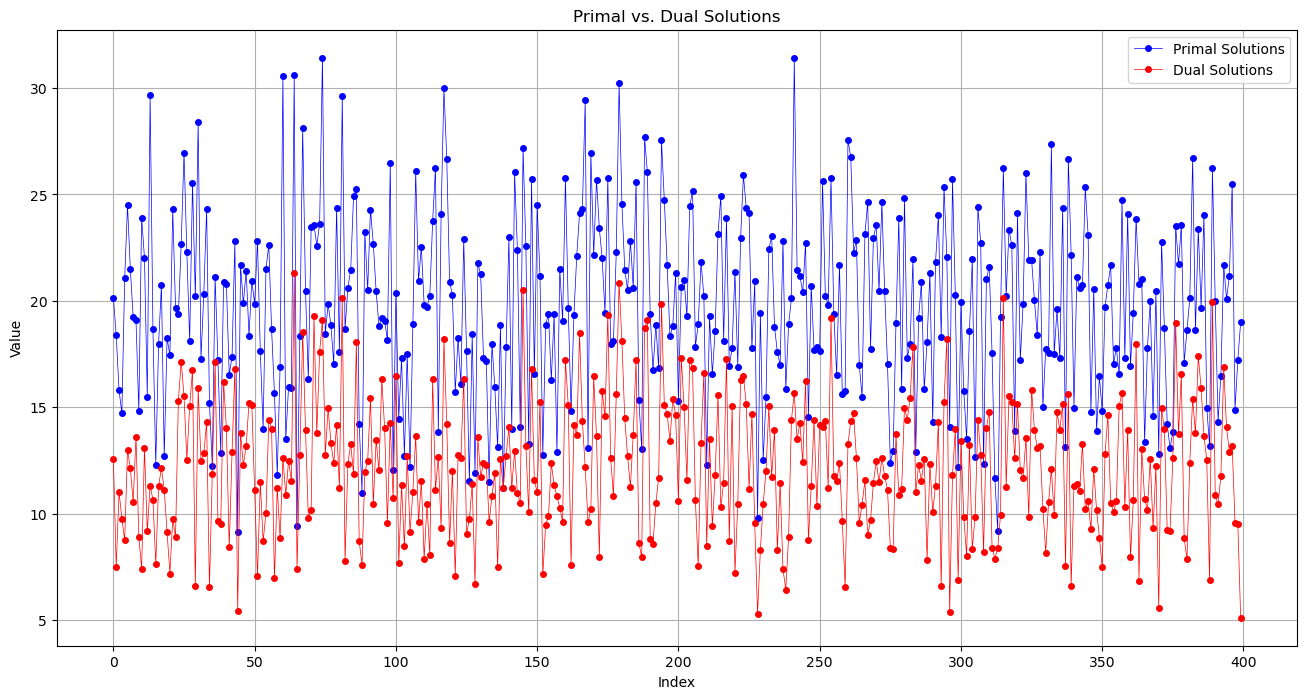

In [9]:
# Set up lists to hold primal and dual solutions
primal_solutions = []
dual_solutions = []
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation for efficiency
    for batch in test_loader:
        sets = batch[0].to(device)

        # Get batched primal and dual solutions
        sets_results = model.predict_interval(sets)
            
        # Separate primal and dual solutions
        for sol_prim, sol_dual in sets_results:
            primal_solutions.append(sol_prim.item())  # Assuming sol_prim is a tensor
            dual_solutions.append(sol_dual.item())    # Assuming sol_dual is a tensor

        # # Since we are breaking after the first batch, we can exit the loop here
        # break  # Remove this line if you want to process more batches

# Convert to numpy arrays for easier plotting
primal_solutions = np.array(primal_solutions)
dual_solutions = np.array(dual_solutions)

# Plotting the results
plt.figure(figsize=(16, 8))

# Plot primal solutions in blue
plt.plot(primal_solutions, label='Primal Solutions', color='blue', marker='o', linestyle='-',linewidth = 0.5,markersize = 4)

# Plot dual solutions in red
plt.plot(dual_solutions, label='Dual Solutions', color='red', marker='o', linestyle='-',linewidth = 0.5,markersize = 4)

plt.title('Primal vs. Dual Solutions')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

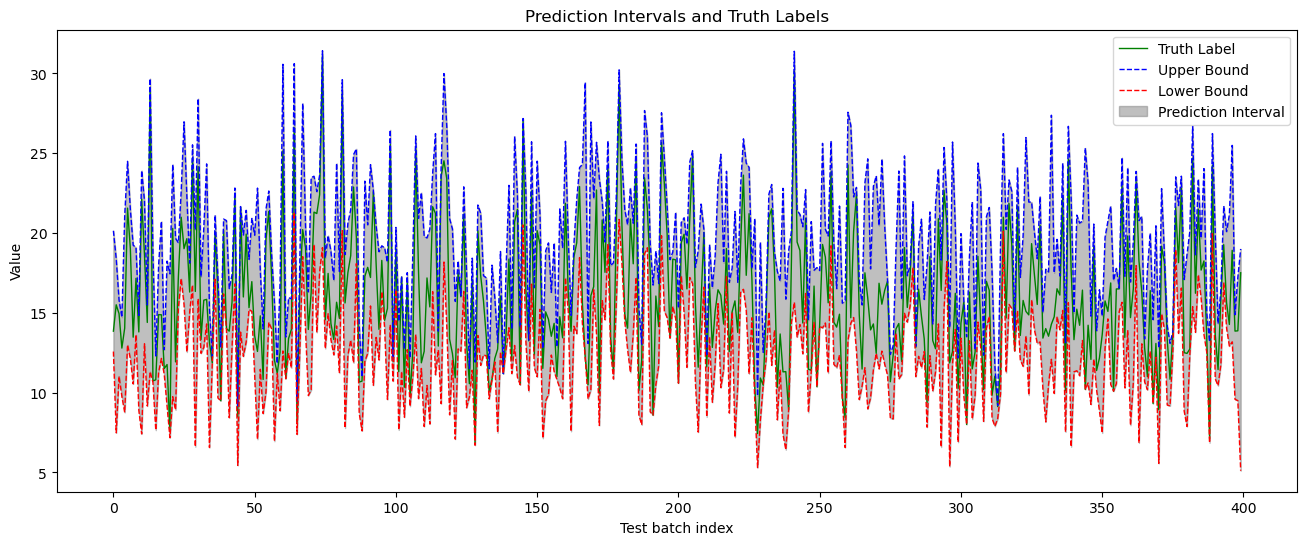

In [12]:
preds = [(dual,primal) for dual,primal in zip(dual_solutions,primal_solutions)]
x = range(len(test_batches))  # x-axis values (can be indices or actual values)
primal_bounds = [pred[1] for pred in preds]
dual_bounds = [pred[0] for pred in preds]
true_label = [wass_hungarian(input).cpu() for input in test_batches]         # True label (ground truth)

# Plotting
plt.figure(figsize=(16, 6))
plt.plot(x, true_label, label='Truth Label', color='green', linewidth=1)
plt.plot(x, primal_bounds, label='Upper Bound', color='blue', linestyle='--', linewidth=1)
plt.plot(x, dual_bounds, label='Lower Bound', color='red', linestyle='--', linewidth=1)

# Shading the area between the lower and upper bounds
plt.fill_between(x, dual_bounds, primal_bounds, color='gray', alpha=0.5, label='Prediction Interval')

# Labels and legend
plt.xlabel('Test batch index')
plt.ylabel('Value')
plt.title('Prediction Intervals and Truth Labels')
plt.legend()

# Show the plot
plt.show()


In [11]:
validity_array = np.array(primal_solutions) > np.array(dual_solutions)
if(False in validity_array):
    print("There is a problem")
else:
    print("Seems to work")

Seems to work
